In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import yaml
from matplotlib.pyplot import imshow
%matplotlib inline
%reload_ext autoreload
%autoreload

In [18]:
video_file = 'Demo of Online Meeting via Zoom with Participants from Around the World-261OCjeg9GI.mp4'
audio_file = video_file + '.wav'
with open('../../api_keys.yml', 'r') as f:
    keys = yaml.load(f)

Read a new frame:  True


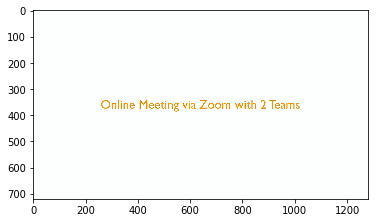

AttributeError: 'module' object has no attribute 'CV_CAP_PROP_FRAME_COUNT'

In [20]:
vidcap = cv2.VideoCapture(video_file)
success, image = vidcap.read()
print 'Read a new frame: ', success
plt.imshow(image)
plt.show()
# cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
vidcap.release()
totalnoframes = vidcap.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT)
totaldurationMS = 1000*totalnoframes/vidcap.get(cv2.cv.CV_CAP_PROP_FPS)
print('Number of frames: %i' % totalnoframes)
print('Duration %f ms' % totalnoframes)

In [27]:
# !ffmpeg -i '$video_file'
# print audio_file
!ffmpeg -y -i '$video_file' -ac 1 -ar 16000 -ss 00:03:05 -t 00:00:10.0 -q:a 0 -map a '$audio_file'

ffmpeg version 3.3.2 Copyright (c) 2000-2017 the FFmpeg developers
  built with Apple LLVM version 8.1.0 (clang-802.0.42)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/3.3.2 --enable-shared --enable-pthreads --enable-gpl --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-libmp3lame --enable-libx264 --enable-libxvid --enable-opencl --disable-lzma --enable-vda
  libavutil      55. 58.100 / 55. 58.100
  libavcodec     57. 89.100 / 57. 89.100
  libavformat    57. 71.100 / 57. 71.100
  libavdevice    57.  6.100 / 57.  6.100
  libavfilter     6. 82.100 /  6. 82.100
  libavresample   3.  5.  0 /  3.  5.  0
  libswscale      4.  6.100 /  4.  6.100
  libswresample   2.  7.100 /  2.  7.100
  libpostproc    54.  5.100 / 54.  5.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'Demo of Online Meeting via Zoom with Participants from Around the World-261OCjeg9GI.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    com

In [9]:
def speech_to_text(filename):
    wf = wave.open(filename)
    if wf.getframerate() != 16000 or wf.getnchannels() != 1 or wf.getsampwidth() != 2:
        print('only support 16000 sample rate, 1 channel and 2 bytes sample width')
        return

    # read less than 10 seconds audio data
    n = wf.getnframes()
    if (n / 16000.0) > 10.0:
        n = 16000 * 10
    print('Seconds: %i' % (n/16000.0))

    frames = wf.readframes(n)

    bing = BingVoice(keys['binq_voice_key_1'], keys['binq_voice_endpoint'])

    text = bing.recognize(frames, language='en-US')
    print('Bing:' + text.encode('utf-8'))
        
speech_to_text(audio_file)

Seconds: 10


RequestError: recognition request failed: Resource Not Found

In [16]:
import requests
import httplib
import uuid
import json

class Microsoft_ASR():
    def __init__(self, binq_key):
        self.sub_key = binq_key
        self.token = None
        pass

    def get_speech_token(self):
        FetchTokenURI = "/sts/v1.0/issueToken"
        header = {'Ocp-Apim-Subscription-Key': self.sub_key}
        conn = httplib.HTTPSConnection('api.cognitive.microsoft.com')
        body = ""
        conn.request("POST", FetchTokenURI, body, header)
        response = conn.getresponse()
        str_data = response.read()
        conn.close()
        self.token = str_data
#         print "Got Token: ", self.token
        return True

    def transcribe(self,speech_file):

        # Grab the token if we need it
        if self.token is None:
            print "No Token... Getting one"
            self.get_speech_token()

        endpoint = 'https://speech.platform.bing.com/recognize'
        request_id = uuid.uuid4()
        # Params form Microsoft Example 
        params = {'scenarios': 'ulm',
                  'appid': 'D4D52672-91D7-4C74-8AD8-42B1D98141A5',
                  'locale': 'en-US',
                  'version': '3.0',
                  'format': 'json',
                  'instanceid': '565D69FF-E928-4B7E-87DA-9A750B96D9E3',
                  'requestid': uuid.uuid4(),
                  'device.os': 'linux'}
        content_type = "audio/wav; codec=""audio/pcm""; samplerate=16000"

        def stream_audio_file(speech_file, chunk_size=1024):
            with open(speech_file, 'rb') as f:
                while 1:
                    data = f.read(1024)
                    if not data:
                        break
                    yield data

        headers = {'Authorization': 'Bearer ' + self.token, 
                   'Content-Type': content_type}
        resp = requests.post(endpoint, 
                            params=params, 
                            data=stream_audio_file(speech_file), 
                            headers=headers)
#         print(resp.text)
        val = json.loads(resp.text)
        return val["results"][0]["name"], val["results"][0]["confidence"]

In [17]:
ms_asr = Microsoft_ASR(keys['binq_voice_key_1'])
ms_asr.get_speech_token()
text, confidence = ms_asr.transcribe(audio_file)
print "Text: ", text
print "Confidence: ", confidence

Text:  open real estate developer who would like to build a something on on that piece of land OK now just
Confidence:  0.8855618
